In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_text

import warnings
warnings. filterwarnings('ignore')

In [4]:
#read in the data, and display the first few rows 
df = pd.read_csv("heart_2020_cleaned.csv")
df.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


In [5]:
# Check NA value
df.isna().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

In [6]:
# Check all unique values of each variable
for col in df:
    print(f'{col}: {df[col].unique()}')

# Diabetic has 2 abnormal values (not Yes and No)
# AgeCategory, Race, and GenHealth have multiple categorical values

HeartDisease: ['No' 'Yes']
BMI: [16.6  20.34 26.58 ... 62.42 51.46 46.56]
Smoking: ['Yes' 'No']
AlcoholDrinking: ['No' 'Yes']
Stroke: ['No' 'Yes']
PhysicalHealth: [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.]
MentalHealth: [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
DiffWalking: ['No' 'Yes']
Sex: ['Female' 'Male']
AgeCategory: ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Race: ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic: ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity: ['Yes' 'No']
GenHealth: ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
SleepTime: [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
 17. 24. 19. 21. 22. 23.]
Asthma: ['Yes' 'No']
KidneyDisease: 

In [7]:
# Encode values:
df.replace(('Yes', 'No'), (1,0), inplace=True)
df.replace(('Yes (during pregnancy)', 'No, borderline diabetes'), (1,0), inplace=True)
df.replace(('Male', 'Female'), (1,0), inplace=True)

In [8]:
# Race is categorical (nominal) -> One-hot encoding
# GenHealth and AgeCategory is ordinal -> Rank data
# One-hot encoding:
# For Regression, we use N-1 (drop first or last column of One Hot Coded new feature ). 
# Still, for classification, the recommendation is to use all N columns without as most of the tree-based algorithm 
# builds a tree based on all available variables.

In [9]:
# Create a copy of original df
df_copy = copy.copy(df)

In [10]:
# One-hot encoding Race
df_copy = df_copy.join(pd.get_dummies(df_copy['Race'], drop_first=False)) #Keep all newly generated features for classification
df_copy = df_copy.drop(columns="Race")
df_copy.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White
0,0,16.60,1,0,0,3.0,30.0,0,0,55-59,...,5.0,1,0,1,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80 or older,...,7.0,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,65-69,...,8.0,1,0,0,0,0,0,0,0,1


In [11]:
# Encode GenHealth using WOE (weight of evidence) method. Read more at: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
# Calculate probability of HeartDisease = 1 for each category of GenHealth
woe_df_copy = df_copy.groupby('GenHealth')['HeartDisease'].mean()
woe_df_copy = pd.DataFrame(woe_df_copy)
# Rename col name to HeartDisease_Yes
woe_df_copy = woe_df_copy.rename(columns = {'HeartDisease':'HeartDisease_Yes'})
woe_df_copy

,HeartDisease_Yes
GenHealth,
Excellent,0.022441
Fair,0.204285
Good,0.102632
Poor,0.341040
Very good,0.047261


In [12]:
# Calculate probability of HeartDisease = 0
woe_df_copy['HeartDisease_No'] = 1 - woe_df_copy.HeartDisease_Yes
woe_df_copy

,HeartDisease_Yes,HeartDisease_No
GenHealth,,
Excellent,0.022441,0.977559
Fair,0.204285,0.795715
Good,0.102632,0.897368
Poor,0.341040,0.658960
Very good,0.047261,0.952739


In [13]:
# Compute WoE
woe_df_copy['WOE'] = np.log(woe_df_copy.HeartDisease_Yes/woe_df_copy.HeartDisease_No)
woe_df_copy

,HeartDisease_Yes,HeartDisease_No,WOE
GenHealth,,,
Excellent,0.022441,0.977559,-3.774170
Fair,0.204285,0.795715,-1.359723
Good,0.102632,0.897368,-2.168318
Poor,0.341040,0.658960,-0.658663
Very good,0.047261,0.952739,-3.003664


In [14]:
# Map GenHealth values in df_copy with WOE values
df_copy.loc[:,'GenHealth_encoded'] = df_copy['GenHealth'].map(woe_df_copy['WOE'])
df_copy = df_copy.drop(columns="GenHealth")

In [15]:
# Encode AgeCategory
# for loop for age category
new_ages = []
for age_group in df_copy["AgeCategory"]:
    low_age = int(age_group[:2]) # The 2 first characters
    if low_age == 80:
        new_ages.append(low_age)
    else:
        high_age = int(age_group[-2:]) # The 2 last characters
        mid_age = (low_age + high_age) / 2
        new_ages.append(mid_age)
        
# Adding new_ages to df_copy and remove AgeCategory
df_copy["UpdatedAges"] = new_ages
df_copy = df_copy.drop(columns="AgeCategory")

In [16]:
#looks for correlation between feature variables
df_copy.corr()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,...,KidneyDisease,SkinCancer,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White,GenHealth_encoded,UpdatedAges
HeartDisease,1.000000,0.051803,0.107764,-0.032080,0.196835,0.170721,0.028591,0.201258,0.070040,0.174782,...,0.145197,0.093317,0.008547,-0.030262,-0.010156,-0.036163,-0.003039,0.040121,0.242472,0.231583
BMI,0.051803,1.000000,0.023118,-0.038816,0.019733,0.109788,0.064131,0.181678,0.026940,0.200443,...,0.050768,-0.033644,0.026347,-0.078643,0.080672,0.023750,0.012535,-0.049060,0.231642,-0.000446
Smoking,0.107764,0.023118,1.000000,0.111768,0.061226,0.115352,0.085157,0.120074,0.085052,0.055544,...,0.034920,0.033977,0.035667,-0.060308,-0.038249,-0.066873,0.016205,0.072367,0.174624,0.130612
AlcoholDrinking,-0.032080,-0.038816,0.111768,1.000000,-0.019858,-0.017254,0.051282,-0.035328,0.004200,-0.057786,...,-0.028280,-0.005702,-0.004243,-0.022275,-0.025980,-0.015554,0.005455,0.033342,-0.029797,-0.058587
Stroke,0.196835,0.019733,0.061226,-0.019858,1.000000,0.137014,0.046467,0.174143,-0.003091,0.104467,...,0.091167,0.048116,0.014357,-0.016060,0.024819,-0.025823,0.005743,0.001154,0.167311,0.136738
PhysicalHealth,0.170721,0.109788,0.115352,-0.017254,0.137014,1.000000,0.287987,0.428373,-0.040904,0.153975,...,0.142197,0.041700,0.022955,-0.035229,0.011371,-0.005571,0.016102,-0.003968,0.478536,0.111010
MentalHealth,0.028591,0.064131,0.085157,0.051282,0.046467,0.287987,1.000000,0.152235,-0.100058,0.029709,...,0.037281,-0.033412,0.018394,-0.023113,0.010944,0.011167,0.031385,-0.024489,0.240324,-0.155327
DiffWalking,0.201258,0.181678,0.120074,-0.035328,0.174143,0.428373,0.152235,1.000000,-0.068860,0.209255,...,0.153064,0.064840,0.025205,-0.038830,0.039615,-0.008214,0.008483,-0.015516,0.412623,0.241328
Sex,0.070040,0.026940,0.085052,0.004200,-0.003091,-0.040904,-0.100058,-0.068860,1.000000,-0.002054,...,-0.009084,0.013434,-0.003434,0.013716,-0.037280,-0.003607,0.008762,0.017314,-0.025793,-0.067001
Diabetic,0.174782,0.200443,0.055544,-0.057786,0.104467,0.153975,0.029709,0.209255,-0.002054,1.000000,...,0.149113,0.034077,0.026691,-0.012519,0.053722,0.007259,0.006349,-0.043658,0.270784,0.198081


In [17]:
# retrieve the array of data
data = df_copy.values
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:] #all other variables
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

In [16]:
classifiers = {0: (RandomForestClassifier()),
               1: (linear_model.LogisticRegression()),
               2: (DecisionTreeClassifier())}
parameters = {0: {'n_estimators': [5,10,100], 'random_state': [0]},
              1: {'max_iter': [5000], 'C':[0.01,1,100]},
              2: {'criterion': ['entropy'], 'max_depth':[1,3,None]}}

In [17]:
for i in np.arange(0,len(classifiers)):
    model = GridSearchCV(classifiers[i], parameters[i]).fit(X_train, y_train)
    print(f'Classifier {classifiers[i]} has a best accuracy score of {model.score(X_valid, y_valid):.3}')
    print(f'Its respective best parameters = {model.best_params_}') 

Classifier RandomForestClassifier() has a best accuracy score of 0.905
Its respective best parameters = {'n_estimators': 100, 'random_state': 0}
Classifier LogisticRegression() has a best accuracy score of 0.917
Its respective best parameters = {'C': 100, 'max_iter': 5000}
Classifier DecisionTreeClassifier() has a best accuracy score of 0.914
Its respective best parameters = {'criterion': 'entropy', 'max_depth': 1}


In [18]:
model = linear_model.LogisticRegression(max_iter = 5000, C = 100)
model.fit(X_train, y_train)
print(f'Validation data score: {model.score(X_valid, y_valid):.3}')
print(f'Test data score      : {model.score(X_test, y_test):.3}')

Validation data score: 0.916
Test data score      : 0.915


In [19]:
y     = y_test
y_hat = model.predict(X_test)
M = confusion_matrix(y_true=y, y_pred=y_hat)
df = pd.DataFrame(data=M)
print('df:')
print(df)
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.3}')

df:
       0    1
0  28974  268
1   2446  292

TN: 28974, FP: 268, FN: 2446, TP: 292

TPR=0.107, FPR=0.00916, FNR=0.893


In [20]:
coefs = model.coef_
cols = list(df_copy)
cols.remove('HeartDisease')
listcoef = coefs.tolist()
listcoef = listcoef[0]
table = pd.DataFrame()
table['Variables'] = cols
table['Coeficients'] = listcoef
print(table)

                         Variables  Coeficients
0                              BMI     0.008917
1                          Smoking     0.348268
2                  AlcoholDrinking    -0.240519
3                           Stroke     1.044154
4                   PhysicalHealth     0.002061
5                     MentalHealth     0.004218
6                      DiffWalking     0.238808
7                              Sex     0.715309
8                         Diabetic     0.469355
9                 PhysicalActivity     0.020429
10                       SleepTime    -0.028685
11                          Asthma     0.285002
12                   KidneyDisease     0.573590
13                      SkinCancer     0.117036
14  American Indian/Alaskan Native    -0.609911
15                           Asian    -1.054690
16                           Black    -0.906037
17                        Hispanic    -0.797958
18                           Other    -0.592686
19                           White    -0

df:
       0  1
0  29242  0
1   2737  0

TN: 29242, FP: 0, FN: 2737, TP: 0

TPR=0.0, FPR=0.0, FNR=1.0


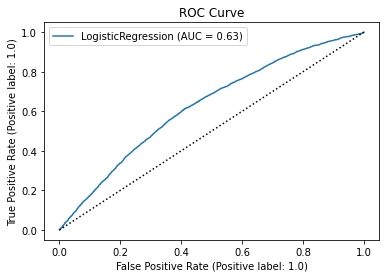

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.replace(('Yes', 'No'), (1,0), inplace=True)
df.replace(('Yes (during pregnancy)', 'No, borderline diabetes'), (1,0), inplace=True)
df.replace(('Male', 'Female'), (1,0), inplace=True)
df_copy = copy.copy(df)
df_copy = df_copy.join(pd.get_dummies(df_copy['Race'], drop_first=False)) #Keep all newly generated features for classification
df_copy = df_copy.drop(columns="Race")
woe_df_copy = df_copy.groupby('GenHealth')['HeartDisease'].mean()
woe_df_copy = pd.DataFrame(woe_df_copy)
# Rename col name to HeartDisease_Yes
woe_df_copy = woe_df_copy.rename(columns = {'HeartDisease':'HeartDisease_Yes'})
woe_df_copy['HeartDisease_No'] = 1 - woe_df_copy.HeartDisease_Yes
woe_df_copy['WOE'] = np.log(woe_df_copy.HeartDisease_Yes/woe_df_copy.HeartDisease_No)
df_copy.loc[:,'GenHealth_encoded'] = df_copy['GenHealth'].map(woe_df_copy['WOE'])
df_copy = df_copy.drop(columns="GenHealth")
new_ages = []
for age_group in df_copy["AgeCategory"]:
    low_age = int(age_group[:2]) # The 2 first characters
    if low_age == 80:
        new_ages.append(low_age)
    else:
        high_age = int(age_group[-2:]) # The 2 last characters
        mid_age = (low_age + high_age) / 2
        new_ages.append(mid_age)
        
# Adding new_ages to df_copy and remove AgeCategory
df_copy["UpdatedAges"] = new_ages
df_copy = df_copy.drop(columns="AgeCategory")
data = df_copy.values
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:3]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')
clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

df:
       0   1
0  29219  23
1   2706  31

TN: 29219, FP: 23, FN: 2706, TP: 31

TPR=0.0113, FPR=0.000787, FNR=0.98867


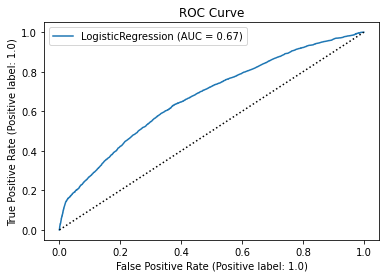

In [3]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.replace(('Yes', 'No'), (1,0), inplace=True)
df.replace(('Yes (during pregnancy)', 'No, borderline diabetes'), (1,0), inplace=True)
df.replace(('Male', 'Female'), (1,0), inplace=True)
df_copy = copy.copy(df)
df_copy = df_copy.join(pd.get_dummies(df_copy['Race'], drop_first=False)) #Keep all newly generated features for classification
df_copy = df_copy.drop(columns="Race")
woe_df_copy = df_copy.groupby('GenHealth')['HeartDisease'].mean()
woe_df_copy = pd.DataFrame(woe_df_copy)
# Rename col name to HeartDisease_Yes
woe_df_copy = woe_df_copy.rename(columns = {'HeartDisease':'HeartDisease_Yes'})
woe_df_copy['HeartDisease_No'] = 1 - woe_df_copy.HeartDisease_Yes
woe_df_copy['WOE'] = np.log(woe_df_copy.HeartDisease_Yes/woe_df_copy.HeartDisease_No)
df_copy.loc[:,'GenHealth_encoded'] = df_copy['GenHealth'].map(woe_df_copy['WOE'])
df_copy = df_copy.drop(columns="GenHealth")
new_ages = []
for age_group in df_copy["AgeCategory"]:
    low_age = int(age_group[:2]) # The 2 first characters
    if low_age == 80:
        new_ages.append(low_age)
    else:
        high_age = int(age_group[-2:]) # The 2 last characters
        mid_age = (low_age + high_age) / 2
        new_ages.append(mid_age)
        
# Adding new_ages to df_copy and remove AgeCategory
df_copy["UpdatedAges"] = new_ages
df_copy = df_copy.drop(columns="AgeCategory")
data = df_copy.values
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:5]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')
clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

df:
       0    1
0  28992  250
1   2423  314

TN: 28992, FP: 250, FN: 2423, TP: 314

TPR=0.115, FPR=0.00855, FNR=0.88528


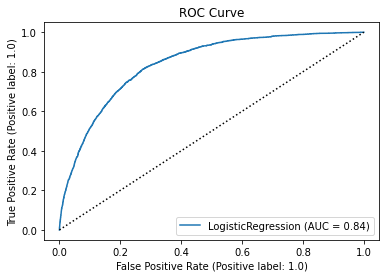

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.replace(('Yes', 'No'), (1,0), inplace=True)
df.replace(('Yes (during pregnancy)', 'No, borderline diabetes'), (1,0), inplace=True)
df.replace(('Male', 'Female'), (1,0), inplace=True)
df_copy = copy.copy(df)
df_copy = df_copy.join(pd.get_dummies(df_copy['Race'], drop_first=False)) #Keep all newly generated features for classification
df_copy = df_copy.drop(columns="Race")
woe_df_copy = df_copy.groupby('GenHealth')['HeartDisease'].mean()
woe_df_copy = pd.DataFrame(woe_df_copy)
# Rename col name to HeartDisease_Yes
woe_df_copy = woe_df_copy.rename(columns = {'HeartDisease':'HeartDisease_Yes'})
woe_df_copy['HeartDisease_No'] = 1 - woe_df_copy.HeartDisease_Yes
woe_df_copy['WOE'] = np.log(woe_df_copy.HeartDisease_Yes/woe_df_copy.HeartDisease_No)
df_copy.loc[:,'GenHealth_encoded'] = df_copy['GenHealth'].map(woe_df_copy['WOE'])
df_copy = df_copy.drop(columns="GenHealth")
new_ages = []
for age_group in df_copy["AgeCategory"]:
    low_age = int(age_group[:2]) # The 2 first characters
    if low_age == 80:
        new_ages.append(low_age)
    else:
        high_age = int(age_group[-2:]) # The 2 last characters
        mid_age = (low_age + high_age) / 2
        new_ages.append(mid_age)
        
# Adding new_ages to df_copy and remove AgeCategory
df_copy["UpdatedAges"] = new_ages
df_copy = df_copy.drop(columns="AgeCategory")
data = df_copy.values
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

In [3]:
print(clf.score(X_valid, y_valid))
print(clf.score(X_test, y_test))

0.9164138966196567
0.915134459036898
